## **0. DiffusionPipeline**
> Original Source: https://huggingface.co/docs/diffusers/quicktour, https://huggingface.co/docs/diffusers/stable_diffusion

```
> Components of DiffusionPipeline
> Local Pipeline
> Swapping Schedulers
> Models
> Schedulers
> Efficient Diffusion: Speed
> Efficient Diffusion: Memory
> Efficient Diffusion: Quaility
```

In [36]:
import numpy as np
import torch
import tqdm
import matplotlib.pyplot as plt

from diffusers import DiffusionPipeline
from diffusers import EulerDiscreteScheduler
from diffusers import UNet2DModel
from diffusers import DDPMScheduler
from diffusers import DPMSolverMultistepScheduler
from diffusers import AutoencoderKL

from diffusers.utils import make_image_grid

----
### **Components of DiffusionPipeline**
- The `DiffusionPipeline` is the easiest way to use a pretrained diffusion system for inference.
- It is an end-to-end system containing the model and the scheduler.
- We can use the `DiffusionPipeline` for any checkpoint stored on the Hugging Face Hub.

- **Download 15 files for `stable-diffusion-v1-5`**
  - 15 files are being fetched, including model weights, configuration files, and tokenizer data.
<br>

| Object Name| Description |
|--------------|-------------------------------------|
| model_index.json     | Metadata file that specifies the types and locations of each pipeline component. |
| model.safetensors (492M)   | Contains weights for one of the trained models (e.g., text encoder).   |
| model.safetensors (1.22G)  | Contains weights for another model component, such as the VAE or U-Net.  |
| preprocessor_config.json  | Configuration file for the preprocessor, defining how inputs are processed before the model.  |
| config.json (617B)         | Configuration file that contains model hyperparameters like hidden size, number of layers.   |
| special_tokens_map.json   | Maps special tokens like `[CLS]` or `[PAD]` used during tokenization.     |
| scheduler_config.json       | Configuration for the noise scheduler used during the diffusion process.|
| config.json (4.72kB)  | Another configuration file for a different component.  |
| diffusion_pytorch_model.safetensors (3.44G) | The main diffusion model (e.g., U-Net) used for denoising and image reconstruction. |
| merges.txt    | Defines merge rules used by the tokenizer with Byte Pair Encoding (BPE).     |
| tokenizer_config.json   | Configuration file for the tokenizer used to encode input text.   | 
| vocab.json      | Vocabulary file for the tokenizer that defines how text is split into tokens.  |
| diffusion_pytorch_model.safetensors (335M)| Weights for another diffusion-related component, possibly an auxiliary network. |


In [3]:
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

- The `DiffusionPipeline` downloads and caches all modeling, tokenization, and scheduling components.
  - Stable Diffusion pipeline is composed of the `UNet2DConditionModel` and `PNDMScheduler` among other things.

In [4]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "PNDMScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [6]:
pipeline.to("cuda")

### **Local Pipeline**
- You can also use the pipeline locally. The only difference is you need to download the weights first:

```
!git lfs install
!git clone https://huggingface.co/stable-diffusion-v1-5/stable-diffusion-v1-5
```

In [8]:
pipeline = DiffusionPipeline.from_pretrained("./stable-diffusion-v1-5", use_safetensors=True)

### **Swapping Schedulers**
- Different schedulers come with different denoising speeds and quality trade-offs.
- The best way to find out which one works best for you is to try them out.
- To replace the default `PNDMScheduler` with the `EulerDiscreteScheduler`, load it with the `from_config()` method:
  - Try generating an image with the new scheduler and see if you notice a difference

In [9]:
pipeline = DiffusionPipeline.from_pretrained("stable-diffusion-v1-5/stable-diffusion-v1-5", use_safetensors=True)
pipeline.scheduler = EulerDiscreteScheduler.from_config(pipeline.scheduler.config)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [10]:
pipeline

StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.33.1",
  "_name_or_path": "stable-diffusion-v1-5/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "image_encoder": [
    null,
    null
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

### **Models**
- Most models take a noisy sample, and at each timestep it predicts the noise residual.
  - Other models learn to predict the previous sample directly or the velocity or v-prediction, the difference between a less noisy image and the input image.
  - You can mix and match models to create other diffusion systems.

- Models are initiated with the `from_pretrained()` method which also locally caches the model weights so it is faster the next time you load the model.
- You’ll load the `UNet2DModel`, a basic unconditional image generation model with a checkpoint trained on cat images:

In [11]:
repo_id = "google/ddpm-cat-256"
model = UNet2DModel.from_pretrained(repo_id, use_safetensors=True)

- The model configuration is a 🧊 frozen 🧊 dictionary, which means those parameters can’t be changed after the model is created. 
  - Other parameters can still be adjusted during inference.

| Object Name                        | Description           |
|-------------------------------------|--------------------------------|
| `sample_size`    | the height and width dimension of the input sample.    |
| `in_channels`   | the number of input channels of the input sample.   |
| `down_block_types` and `up_block_types`  | the type of down- and upsampling blocks used to create the UNet architecture.     |
| `block_out_channels`  | the number of output channels of the downsampling blocks; also used in reverse order for the number of input channels of the upsampling blocks.    |
| `layers_per_block`  | the number of ResNet blocks present in each UNet block.  |

In [12]:
model.config

FrozenDict([('sample_size', 256),
            ('in_channels', 3),
            ('out_channels', 3),
            ('center_input_sample', False),
            ('time_embedding_type', 'positional'),
            ('time_embedding_dim', None),
            ('freq_shift', 1),
            ('flip_sin_to_cos', False),
            ('down_block_types',
             ['DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'DownBlock2D',
              'AttnDownBlock2D',
              'DownBlock2D']),
            ('mid_block_type', 'UNetMidBlock2D'),
            ('up_block_types',
             ['UpBlock2D',
              'AttnUpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D',
              'UpBlock2D']),
            ('block_out_channels', [128, 128, 256, 256, 512, 512]),
            ('layers_per_block', 2),
            ('mid_block_scale_factor', 1),
            ('downsample_padding', 0),
            ('downsample_type', 'conv'),
   

- To use the model for inference, create the image shape with random Gaussian noise.
- It should have a batch axis because the model can receive multiple random noises, a channel axis corresponding to the number of input channels, and a sample_size axis for the height and width of the image:

In [13]:
torch.manual_seed(0)

noisy_sample = torch.randn(1, model.config.in_channels, model.config.sample_size, model.config.sample_size)
noisy_sample.shape

torch.Size([1, 3, 256, 256])

- For inference, pass the noisy image and a **timestep** to the model.
- The timestep indicates how noisy the input image is, with more noise at the beginning and less at the end.
- This helps the model **determine its position in the diffusion process**, whether it is closer to the start or the end.
  - Use the sample method to get the model output:

In [14]:
with torch.no_grad():
    noisy_residual = model(sample=noisy_sample, timestep=2).sample

### **Schedulers**
- Schedulers manage going from a noisy sample to a less noisy sample given the model output 
  - In this case, it is the `noisy_residual`.
 
- For the quicktour, you’ll instantiate the DDPMScheduler with its `from_config()` method:

| Parameter Name     | Description        |
|----------|-------------------------|
| `_class_name`   | The name of the scheduler class being used. `"DDPMScheduler"` indicates a standard DDPM scheduler.      |
| `_diffusers_version`  | The version of the Diffusers library used to create or last update this configuration.               |
| `beta_start`   | The starting value of beta for the linear noise schedule. Controls how much noise is added early on.    |
| `beta_end`  | The ending value of beta for the linear noise schedule. Controls how much noise is added at the end.    |
| `beta_schedule`  | The type of schedule used to control how betas change over time. `"linear"` means linearly increasing.  |
| `clip_sample`  | Whether to clip the predicted sample between `-1.0` and `1.0` to stabilize training or inference.     |
| `clip_sample_range`| The range within which to clip samples if `clip_sample=True`.       |
| `dynamic_thresholding_ratio`  | Ratio used for dynamic thresholding during sampling to avoid saturation.          |
| `num_train_timesteps` | The length of the denoising process, i.e., the number of timesteps required to process random Gaussian noise into a data sample.    |
| `prediction_type`  | What the model is trained to predict: `"epsilon"` = noise, `"sample"` = denoised sample, etc.     |
| `rescale_betas_zero_snr` | Whether to rescale betas for zero Signal-to-Noise Ratio (SNR) setting.       |
| `sample_max_value`   | Maximum absolute value the sample is allowed to take (used during clipping or thresholding).     |
| `steps_offset`  | Offset added to the timestep index. Can help align with training if a shift was applied.  |
| `thresholding`    | Whether to apply thresholding (e.g., dynamic) to samples to prevent outlier pixel values.    |
| `timestep_spacing`  | Method of spacing timesteps. `"leading"` means time steps start at the beginning and progress uniformly. |
| `trained_betas`  | If provided, a custom list of betas learned during training; otherwise uses the scheduled ones.    |
| `variance_type`   | Type of variance to use during sampling: `"fixed_small"`, `"fixed_large"`, etc.     |


In [15]:
scheduler = DDPMScheduler.from_pretrained(repo_id)
scheduler

DDPMScheduler {
  "_class_name": "DDPMScheduler",
  "_diffusers_version": "0.33.1",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null,
  "variance_type": "fixed_small"
}

- To predict a slightly less noisy image, pass the following to the scheduler’s `step()` method:
  - model output, timestep, and current sample.

In [16]:
less_noisy_sample = scheduler.step(model_output=noisy_residual, timestep=2, sample=noisy_sample).prev_sample
less_noisy_sample.shape

torch.Size([1, 3, 256, 256])

- Create a denoising loop that predicts the residual of the less noisy sample, and computes the less noisy sample with the scheduler:

In [18]:
sample = noisy_sample

for i, t in enumerate(tqdm.tqdm(scheduler.timesteps)):
    # 1. predict noise residual
    with torch.no_grad():
        residual = model(sample, t).sample

    # 2. compute less noisy image and set x_t -> x_t-1
    sample = scheduler.step(residual, t, sample).prev_sample

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [14:34<00:00,  1.14it/s]


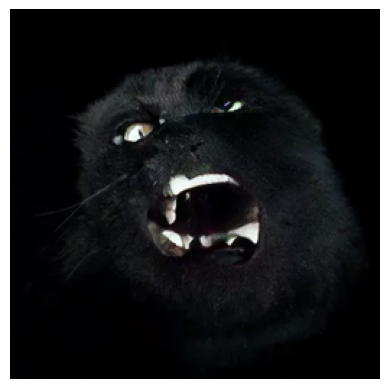

In [33]:
image_processed = (sample.cpu().permute(0, 2, 3, 1) + 1.0) * 127.5
image_processed = image_processed.numpy().astype(np.uint8)

plt.imshow(image_processed[0])
plt.axis("off")
plt.show()

### **Efficient Diffusion: Speed**
- Often times, you have to run the `DiffusionPipeline` several times.
  - But generating something out of nothing is a computationally intensive process, especially if you’re running inference over and over again.
- This is why it’s important to get the most computational (speed) and memory (GPU vRAM) efficiency from the pipeline to reduce the time between inference cycles so you can iterate faster.

In [ ]:
prompt = "portrait photo of a old warrior chief"

In [ ]:
pipeline = pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(0)

- This process took ~30 seconds on a T4 GPU (it might be faster if your allocated GPU is better than a T4).
  - By default, the `DiffusionPipeline` runs inference with **full float32 precision for 50 inference steps**.
  - You can speed this up by switching to a **lower precision like float16** or running fewer inference steps.

In [ ]:
image = pipeline(prompt, generator=generator).images[0]

- Loading the model in **float16** and generate an image:
- This time, it only took ~11 seconds to generate the image, which is almost **3x faster** than before.
  - We strongly suggest always running your pipelines in **float16**, and so far, we’ve rarely seen any degradation in output quality.

In [ ]:
pipeline = DiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, use_safetensors=True)
pipeline = pipeline.to("cuda")
generator = torch.Generator("cuda").manual_seed(0)

image = pipeline(prompt, generator=generator).images[0]

- Another option is to **reduce the number of inference steps**.
  - **Choosing a more efficient scheduler** could help decrease the number of steps without sacrificing output quality.
  - You can find which schedulers are compatible with the current model in the `DiffusionPipeline` by calling the compatibles method:

| Scheduler Class Name | Description |
|----------------------|-------------|
| `DDPMScheduler` | The original scheduler from Denoising Diffusion Probabilistic Models. Simple and robust, but slower. |
| `DDIMScheduler` | DDIM (Denoising Diffusion Implicit Models) scheduler that enables deterministic or stochastic sampling with fewer steps. |
| `PNDMScheduler` | Pseudo Numerical Methods scheduler that improves efficiency and quality over vanilla DDPM. Used in early Stable Diffusion. |
| `DEISMultistepScheduler` | Denoising Explicit Implicit Scheduler, a fast multistep ODE-based method for improved efficiency. |
| `DPMSolverSDEScheduler` | Scheduler designed for SDE-based models, using the DPM-Solver framework to handle stochastic dynamics. |
| `DPMSolverMultistepScheduler` | DPM-Solver++ with multistep support. Balances speed and quality, commonly used in modern pipelines. |
| `DPMSolverSinglestepScheduler` | A single-step version of DPM-Solver++, offering speed with acceptable quality for quick sampling. |
| `EDMEulerScheduler` | Scheduler tailored for EDM (Elucidated Diffusion Models) using the Euler method. Designed for stable and precise inference. |
| `EulerAncestralDiscreteScheduler` | Ancestral variant of Euler’s method, introduces stochasticity to improve sample diversity. |
| `KDPM2AncestralDiscreteScheduler` | A stochastic version of DPM++ 2nd order scheduler using ancestral sampling for more diverse outputs. |
| `LMSDiscreteScheduler` | Linear Multistep scheduler based on pseudo-numerical methods. Offers stable and consistent performance. |
| `HeunDiscreteScheduler` | Uses Heun’s method (2nd order Runge-Kutta), achieving better accuracy over Euler with moderate step sizes. |
| `EulerDiscreteScheduler` | Fast and simple scheduler using the Euler method. Good for fast generation and debugging. |
| `UniPCMultistepScheduler` | Universal Predictor-Corrector scheduler, designed to adaptively balance precision and speed. |
| `KDPM2DiscreteScheduler` | Deterministic variant of DPM++ 2nd order scheduler (Karras style), supports fast and high-quality generation. |


In [34]:
pipeline.scheduler.compatibles

[diffusers.schedulers.scheduling_ddpm.DDPMScheduler,
 diffusers.schedulers.scheduling_ddim.DDIMScheduler,
 diffusers.schedulers.scheduling_pndm.PNDMScheduler,
 diffusers.schedulers.scheduling_deis_multistep.DEISMultistepScheduler,
 diffusers.utils.dummy_torch_and_torchsde_objects.DPMSolverSDEScheduler,
 diffusers.schedulers.scheduling_dpmsolver_multistep.DPMSolverMultistepScheduler,
 diffusers.schedulers.scheduling_dpmsolver_singlestep.DPMSolverSinglestepScheduler,
 diffusers.schedulers.scheduling_edm_euler.EDMEulerScheduler,
 diffusers.schedulers.scheduling_euler_ancestral_discrete.EulerAncestralDiscreteScheduler,
 diffusers.schedulers.scheduling_k_dpm_2_ancestral_discrete.KDPM2AncestralDiscreteScheduler,
 diffusers.utils.dummy_torch_and_scipy_objects.LMSDiscreteScheduler,
 diffusers.schedulers.scheduling_heun_discrete.HeunDiscreteScheduler,
 diffusers.schedulers.scheduling_euler_discrete.EulerDiscreteScheduler,
 diffusers.schedulers.scheduling_unipc_multistep.UniPCMultistepScheduler,

- The Stable Diffusion model uses the `PNDMScheduler` by default which usually requires ~50 inference steps, but more performant schedulers like `DPMSolverMultistepScheduler`, require only ~20 or 25 inference steps.
- Use the `from_config()` method to load a new scheduler: you’ve managed to cut the inference time to just 4 seconds.

In [ ]:
pipeline.scheduler = DPMSolverMultistepScheduler.from_config(pipeline.scheduler.config)

generator = torch.Generator("cuda").manual_seed(0)
image = pipeline(prompt, generator=generator, num_inference_steps=20).images[0]

### **Efficient Diffusion: Memory**
- The other key to improving pipeline performance is **consuming less memory**, which indirectly implies more speed
  - You’re often trying to maximize the number of images generated per second. 
- The easiest way to see **how many images you can generate at once** is to try out different **batch sizes** until you get an `OutOfMemoryError (OOM)`.

- Create a function that’ll generate a batch of images from a list of prompts and Generators. 
  - Make sure to assign each Generator a seed so you can reuse it if it produces a good result.

In [35]:
def get_inputs(batch_size=1):
    generator = [torch.Generator("cuda").manual_seed(i) for i in range(batch_size)]
    prompts = batch_size * [prompt]
    num_inference_steps = 20

    return {"prompt": prompts, "generator": generator, "num_inference_steps": num_inference_steps}

In [ ]:
images = pipeline(**get_inputs(batch_size=4)).images
make_image_grid(images, 2, 2)

- Unless you have a GPU with more vRAM, the code above probably returned an OOM error 
  - Most of the memory is taken up by the `cross-attention layers`. 
  - Instead of running this operation in a batch, you can **run it sequentially to save a significant amount of memory**. 
  - All you have to do is configure the pipeline to use the `enable_attention_slicing()` function:

In [ ]:
pipeline.enable_attention_slicing()

- Increase `batch_size` to 8
- Whereas before you couldn’t even generate a batch of 4 images, now you can generate a batch of 8 images at ~3.5 seconds per image
  - This is probably the fastest you can go on a T4 GPU without sacrificing quality.

In [ ]:
images = pipeline(**get_inputs(batch_size=8)).images

### **Efficient Diffusion: Quaility**
- How to improve the quality of generated images.

#### Better checkpoints
- The Stable Diffusion model is a good starting point, and since its official launch, several improved versions have also been released.
  - However, **using a newer version doesn’t automatically mean you’ll get better results**.
  - You’ll still have to experiment with different checkpoints yourself, and do a little research (such as using negative prompts) to get the best results.
  - There are more and more high-quality checkpoints finetuned to produce certain styles.

In [ ]:
vae = AutoencoderKL.from_pretrained("stabilityai/sd-vae-ft-mse", torch_dtype=torch.float16).to("cuda")
pipeline.vae = vae

images = pipeline(**get_inputs(batch_size=8)).images

#### Better prompt engineering
- The text prompt you use to generate an image is super important, so much so that it is called prompt engineering. 
- Some considerations to keep during prompt engineering are:
  - How is the image or similar images of the one I want to generate stored on the internet?
  - What additional detail can I give that steers the model towards the style I want?
  - With this in mind, let’s improve the prompt to include color and higher quality details:

In [ ]:
prompt += ", tribal panther make up, blue on red, side profile, looking away, serious eyes"
prompt += " 50mm portrait photography, hard rim lighting photography--beta --ar 2:3  --beta --upbeta"